In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv("avganger_haukeland_uke5.csv", header=0)

#remove columns directionRef
df = df.drop(columns=['directionRef'])
#print(df[["aimedArrivalTime", "aimedDepartureTime","arrivalTime","lineRef"]].head(5))
##konverterer til datetime
df["departureTime"] = pd.to_datetime(df["departureTime"])
df["arrivalTime"] = pd.to_datetime(df["arrivalTime"])
df["aimedArrivalTime"] = pd.to_datetime(df["aimedArrivalTime"])
df["aimedDepartureTime"] = pd.to_datetime(df["aimedDepartureTime"])
df["operatingDate"] = pd.to_datetime(df["operatingDate"])

## legger til avvik
df["delayArrival"]=df["arrivalTime"]-df["aimedArrivalTime"]
df["delayDeparture"]=df["departureTime"]-df["aimedDepartureTime"]


# df["rutetidUtenDato"] = df.apply(
#     lambda row: row["departureTime"].time() if pd.isnull(row["aimedArrivalTime"]) else row["aimedArrivalTime"].time(), axis=1
# )
df["rutetidUtenDato"] = np.where(
    pd.isnull(df["aimedArrivalTime"]),
    df["aimedDepartureTime"].dt.time,
    df["aimedArrivalTime"].dt.time
)

print(f"Sjekker nullverdier i rutetidUtendato: {df["rutetidUtenDato"].isnull().sum()}")

# print(df.columns)

sortertEtterLinje = df.groupby("lineRef")
print(sortertEtterLinje["delayArrival"].mean())
print(sortertEtterLinje["delayDeparture"].mean())

##df.describe gir oss veldig spennende statistikk<3
print(df[['delayArrival', 'delayDeparture']].describe())


Sjekker nullverdier i rutetidUtendato: 0
lineRef
SKY:Line:12    0 days 00:01:41.092682926
SKY:Line:16E   0 days 00:00:56.974011299
SKY:Line:27    0 days 00:00:17.483116883
SKY:Line:5     0 days 00:01:53.078838174
SKY:Line:6     0 days 00:01:49.352318958
Name: delayArrival, dtype: timedelta64[ns]
lineRef
SKY:Line:12    0 days 00:02:05.448074679
SKY:Line:16E   0 days 00:01:21.284292035
SKY:Line:27                          NaT
SKY:Line:5     0 days 00:02:15.009623095
SKY:Line:6     0 days 00:02:10.288782816
Name: delayDeparture, dtype: timedelta64[ns]
                    delayArrival             delayDeparture
count                       4524                       4265
mean   0 days 00:01:30.783156498  0 days 00:02:00.309495896
std    0 days 00:02:23.946298573  0 days 00:02:22.181177412
min            -1 days +23:52:34          -1 days +23:56:11
25%            -1 days +23:59:59            0 days 00:00:21
50%              0 days 00:01:07            0 days 00:01:31
75%              0 days 0

In [ ]:
## Finner mest populære linjer og gjennomsnittlig forsinkelse


#litt finere formatering av tiden - lesbarhet for utskrivning av tabell
def stringFormatering(delayDeparture):
    try:
        if (delayDeparture.total_seconds()//60) < 0:
            return f"{int(delayDeparture.total_seconds()//60+1)}m {round(delayDeparture.total_seconds()%60-60,1)}s"
        else:
            return f"{int(delayDeparture.total_seconds()//60)} m {round(delayDeparture.total_seconds()%60,1)}s"
    except ValueError:
        return "NaT"
    

linjer=df.value_counts("lineRef")

linjer_delay=df[["lineRef","delayDeparture","delayArrival"]].groupby("lineRef").agg({"delayDeparture":["max","mean","min"],"delayArrival":["max","mean","min"],"lineRef":"count"}).reset_index()

# print(linjer_delay.size)

linjer_delay.columns=["lineRef","departureMax","departureMean","departureMin","arrivalMax","arrivalMean","arrivalMin","antallAvganger"]
linjer_delay["departureMin"]=linjer_delay["departureMin"].apply(stringFormatering)
linjer_delay["departureMean"]=linjer_delay["departureMean"].apply(stringFormatering)
linjer_delay["departureMax"]=linjer_delay["departureMax"].apply(stringFormatering)
linjer_delay["arrivalMin"]=linjer_delay["arrivalMin"].apply(stringFormatering)
linjer_delay["arrivalMean"]=linjer_delay["arrivalMean"].apply(stringFormatering)
linjer_delay["arrivalMax"]=linjer_delay["arrivalMax"].apply(stringFormatering)

linjer_delay=linjer_delay.sort_values(by="antallAvganger",ascending=False)
#linjer_delay[]
print(linjer_delay.head(5))




        lineRef departureMax departureMean departureMin  arrivalMax  \
3    SKY:Line:5   14 m 14.0s     2 m 15.0s   -3m -36.0s   14 m 1.0s   
4    SKY:Line:6    28 m 3.0s     2 m 10.3s   -3m -49.0s   28 m 3.0s   
1  SKY:Line:16E   14 m 52.0s     1 m 21.3s   -2m -17.0s  14 m 31.0s   
0   SKY:Line:12   16 m 10.0s      2 m 5.4s   -3m -26.0s  15 m 42.0s   
2   SKY:Line:27          NaT           NaT          NaT  20 m 40.0s   

  arrivalMean  arrivalMin  antallAvganger  
3   1 m 53.1s  -3m -49.0s            1286  
4   1 m 49.4s  -3m -49.0s            1284  
1   0 m 57.0s  -2m -44.0s             926  
0   1 m 41.1s  -3m -51.0s             875  
2   0 m 17.5s  -7m -26.0s             432  


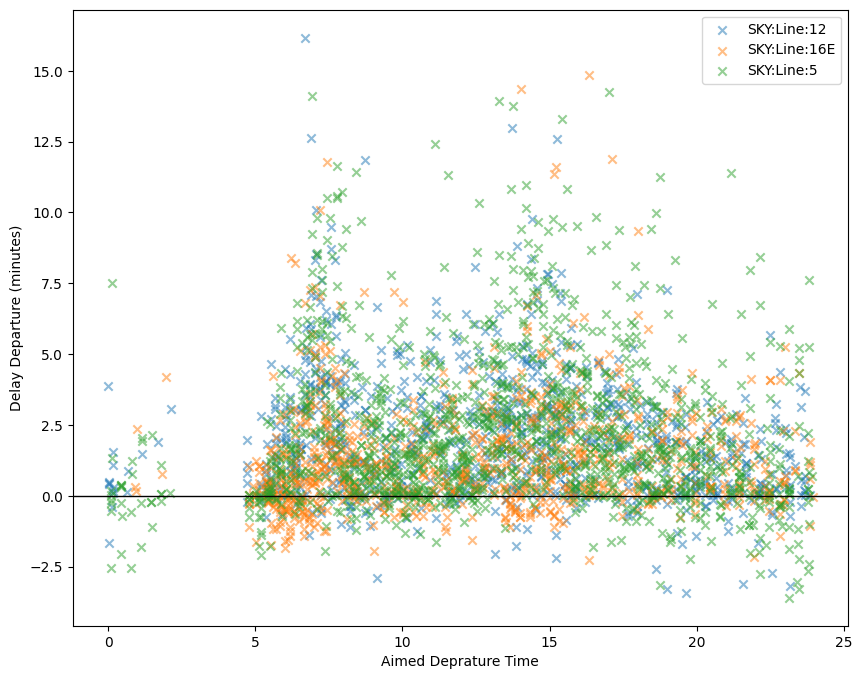

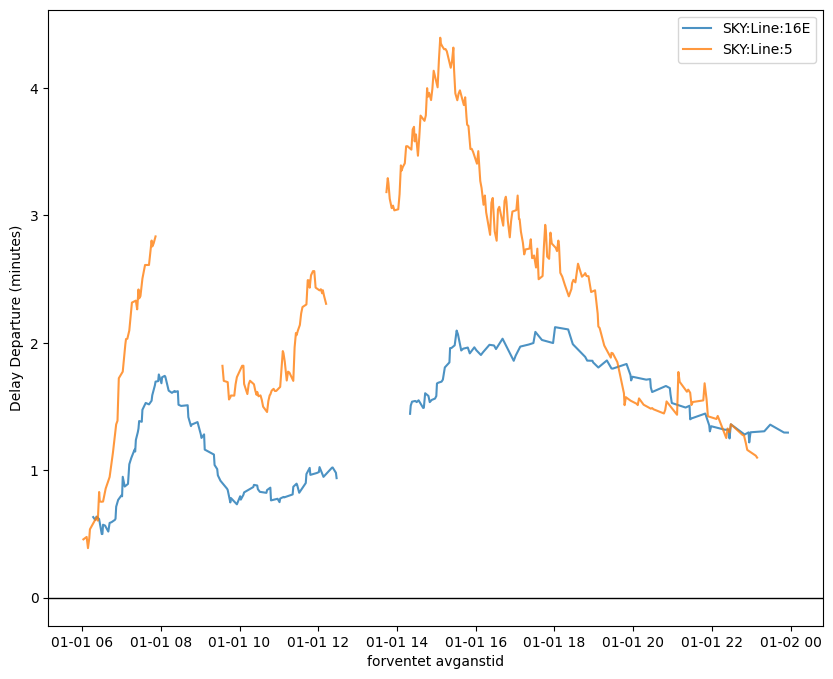

In [2]:
#plotting
#dette plottet viser forsinkelse i avgangstidspunktet for hver linje, man kan velge linjer ved å endre if setningen
plt.figure(1, figsize=(10,8))
for name, group in sortertEtterLinje:
    group.sort_values("rutetidUtenDato")
    linje=name.split(":")[2]
    
    if  linje=="12" or linje=="16E" or linje=="5":
        times_in_minutes = group["rutetidUtenDato"].apply(lambda t: t.hour * 60 + t.minute + t.second/60)
        #plt.plot(times_in_minutes, group["delayArrival"].dt.total_seconds()/60, label=f"{name}", alpha=0.5),
        plt.scatter(times_in_minutes/60, group["delayDeparture"].dt.total_seconds()/60, label=f"{name}", alpha=0.5, marker='x')
        ##plt.scatter(times_in_minutes, group["delayArrival"].dt.total_seconds()/60, label=f"{name}", alpha=0.5)

plt.xlabel("Aimed Deprature Time")
plt.ylabel("Delay Departure (minutes)")
## set x axis to y=0
plt.axhline(0, color='black', lw=1)
plt.legend()

plt.figure(2,figsize=(10,8))
for name, group in sortertEtterLinje:
    group.sort_values("rutetidUtenDato")
    linje = name.split(":")[2]
    
    linjeGruppertetterAvgang = group.groupby("rutetidUtenDato")
    ukesnittSer=linjeGruppertetterAvgang["delayDeparture"].mean()
    ##print(ukesnittSer.index)
    if linje=="16E" or linje=="5":
        #ukesnittSer.rolling(7).mean().plot(label=f"{name}", alpha=0.5)
        #plt.scatter(pd.to_datetime(ukesnittSer.index, format='%H:%M:%S'), (ukesnittSer.dt.total_seconds()/60), label=f"{name}", alpha=0.4, marker=".")
        plt.plot(pd.to_datetime(ukesnittSer.index, format='%H:%M:%S'), (ukesnittSer.dt.total_seconds()/60).rolling(30).mean(), label=f"{name}", alpha=0.8)
plt.xlabel("forventet avganstid")
plt.ylabel("Delay Departure (minutes)")
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.show()

                           delayDeparture
rutetidUtenDato                          
00:17:00           0 days 00:00:18.500000
00:19:00        0 days 00:03:08.833333333
00:37:00           0 days 00:00:06.500000
00:39:00           0 days 00:02:30.500000
00:57:00                -1 days +23:59:59
...                                   ...
23:19:00                  0 days 00:00:57
23:37:00                  0 days 00:01:02
23:39:00        0 days 00:05:34.571428571
23:57:00           0 days 00:00:37.500000
23:59:00           0 days 00:00:47.500000

[219 rows x 1 columns]
rutetidUtenDato
00:17:00      0 days 00:00:18.500000
00:19:00   0 days 00:03:08.833333333
00:37:00      0 days 00:00:06.500000
00:39:00      0 days 00:02:30.500000
00:57:00           -1 days +23:59:59
                      ...           
23:19:00             0 days 00:00:57
23:37:00             0 days 00:01:02
23:39:00   0 days 00:05:34.571428571
23:57:00      0 days 00:00:37.500000
23:59:00      0 days 00:00:47.500000
Name: d

<Axes: xlabel='rutetidUtenDato'>

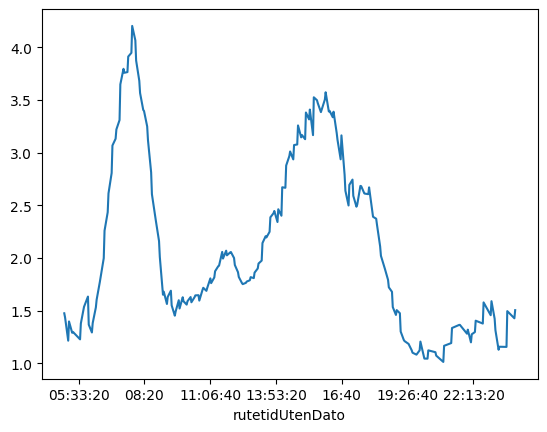

In [3]:
ukesnittDf = pd.DataFrame(ukesnittSer)
print(ukesnittDf)
print(ukesnittSer)
print(ukesnittSer.index)

# Convert timedelta to total seconds for plotting
ukesnittSer_seconds = ukesnittSer.dt.total_seconds() / 60  # convert to minutes
ukesnittSer_seconds.rolling(15).mean().plot()
